<a href="https://colab.research.google.com/github/MaLuWi/guayas_store_project/blob/notebooks/Masterschool_Week3_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from matplotlib import pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
# Note: train file is very large.
# To make sure we fit RAM avaible on Google-Colab, we will load only part of the file
df_train = pd.read_csv('/content/drive/MyDrive/Time Series/datasets/df_train2.csv') #this is the dataset after filtering out for the Guayas region and top3 familys
df_stores = pd.read_csv('/content/drive/MyDrive/Time Series/datasets/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/Time Series/datasets/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/Time Series/datasets/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/Time Series/datasets/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/Time Series/datasets/holidays_events.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Checking the datasets structure**

In [ ]:
df_train.shape

(5219638, 17)

In [ ]:
df_train['date'].describe()

,date
count,5219638
unique,454
top,2014-03-31
freq,11497


In [ ]:
df_train.head()

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,lag_1,lag_7,lag_14,lag_30,roll7_std,is_holiday,pct_chg_7d
0,24,105574,2013-01-02,12.0,0,2013,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1,24,105574,2013-01-03,1.0,0,2013,1,3,3,NaN,12.0,NaN,NaN,NaN,NaN,0,0.0
2,24,105574,2013-01-04,3.0,0,2013,1,4,4,NaN,1.0,NaN,NaN,NaN,NaN,0,0.0
3,24,105574,2013-01-05,4.0,0,2013,1,5,5,NaN,3.0,NaN,NaN,NaN,NaN,1,0.0
4,24,105574,2013-01-06,7.0,0,2013,1,6,6,NaN,4.0,NaN,NaN,NaN,NaN,0,0.0


In [ ]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [ ]:
df_items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [ ]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
df_oil.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


In [ ]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [ ]:
split_date = '2014-01-01'
train = df_train[df_train['date'] < split_date]
test = df_train[df_train['date'] > split_date]

In [ ]:
df_train.shape

(5219638, 17)

In [ ]:
df_train.shape

(5219638, 17)

In [ ]:
df_train

,store_nbr,item_nbr,date,unit_sales,onpromotion,year,month,day,day_of_week,unit_sales_7d_avg,...,is_holiday,pct_chg_7d,city,state,type,cluster,family,class,perishable,is_weekend
0,24,115611,2013-01-02,22.0,False,2013,1,2,2,NaN,...,0,0.0,Guayaquil,Guayas,D,1,GROCERY I,1014,0,False
1,24,115611,2013-01-03,20.0,False,2013,1,3,3,NaN,...,0,0.0,Guayaquil,Guayas,D,1,GROCERY I,1014,0,False
2,24,115611,2013-01-04,39.0,False,2013,1,4,4,NaN,...,0,0.0,Guayaquil,Guayas,D,1,GROCERY I,1014,0,False
3,24,115611,2013-01-05,28.0,False,2013,1,5,5,NaN,...,1,0.0,Guayaquil,Guayas,D,1,GROCERY I,1014,0,True
4,24,115611,2013-01-06,32.0,False,2013,1,6,6,NaN,...,0,0.0,Guayaquil,Guayas,D,1,GROCERY I,1014,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646491,51,1012473,2014-03-27,0.0,False,2014,3,27,3,0.0,...,0,0.0,Guayaquil,Guayas,A,17,CLEANING,3008,0,False
646492,51,1012473,2014-03-28,0.0,False,2014,3,28,4,0.0,...,0,0.0,Guayaquil,Guayas,A,17,CLEANING,3008,0,False
646493,51,1012473,2014-03-29,0.0,False,2014,3,29,5,0.0,...,0,0.0,Guayaquil,Guayas,A,17,CLEANING,3008,0,True
646494,51,1012473,2014-03-30,0.0,False,2014,3,30,6,0.0,...,0,0.0,Guayaquil,Guayas,A,17,CLEANING,3008,0,True


#Apply the Model

In [ ]:
#import the librariers
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb
import matplotlib.pyplot as plt
import pickle

In [ ]:
# Compute total sales per item
item_totals = df_train.groupby('item_nbr')['unit_sales'].sum().sort_values(ascending=False)
# Choose top 150 items
top_items = item_totals.head(150).index.tolist()
# Filter df_train to include only top 150 items
df_train = df_train[df_train['item_nbr'].isin(top_items)]
#I go with the most impactful 10% of items

In [ ]:
# Convert dates to datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Optimize data types in df_train
df_train = df_train.astype({
    'store_nbr': 'category',
    'item_nbr': 'category',
    'onpromotion': 'bool',
    'year': 'int16',
    'month': 'int8',
    'day': 'int8',
    'day_of_week': 'int8',
    'unit_sales_7d_avg': 'float32',
    'lag_1': 'float32',
    'lag_7': 'float32',
    'lag_14': 'float32',
    'lag_30': 'float32',
    'roll7_std': 'float32',
    'pct_chg_7d': 'float32',
    'unit_sales': 'float32'
})

# Merge datasets
df_train = df_train.merge(df_stores, on='store_nbr', how='left')
df_train = df_train.merge(df_items, on='item_nbr', how='left')

# Add is_weekend feature
df_train['is_weekend'] = df_train['day_of_week'].isin([5, 6]).astype('bool')

# Ensure categorical columns
categorical_cols = ['store_nbr', 'item_nbr', 'family', 'city', 'state', 'type_x', 'class']
for col in categorical_cols:
    if col in df_train.columns:
        df_train[col] = df_train[col].astype('category')

# Rename type_x to avoid confusion
df_train = df_train.rename(columns={'type_x': 'store_type'})

In [ ]:
split prep
split_date = '2014-01-01'
train = df_train[df_train['date'] < split_date]
test = df_train[df_train['date'] >= split_date]

In [ ]:
feature_cols = [
    'store_nbr', 'item_nbr', 'onpromotion', 'year', 'month', 'day', 'day_of_week',
    'unit_sales_7d_avg', 'lag_1', 'lag_7', 'lag_14', 'lag_30', 'roll7_std',
    'pct_chg_7d', 'is_weekend', 'city', 'state', 'store_type',
    'cluster', 'family', 'class', 'perishable'
]
# Ensure only existing columns are included
feature_cols = [col for col in feature_cols if col in df_train.columns]
X_train = train[feature_cols]
y_train = train['unit_sales']
X_test = test[feature_cols]
y_test = test['unit_sales']

In [ ]:
models = {
    'XGBoost': {
        'model': xgb.XGBRegressor(objective='reg:squarederror', enable_categorical=True),
        'param_grid': {
            'eta': [0.01, 0.1, 0.3],
            'max_depth': [3, 5, 7, 10],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'n_estimators': [100, 200, 500]
        }
    }
}

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
best_models = {}
best_scores = {}
for model_name, model_info in models.items():
    print(f"Training {model_name}...")
    random_search = RandomizedSearchCV(
        estimator=model_info['model'],
        param_distributions=model_info['param_grid'],
        cv=tscv,
        n_iter=20,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    best_models[model_name] = random_search.best_estimator_
    best_scores[model_name] = random_search.best_score_
    print(f"Best parameters for {model_name}: {random_search.best_params_}")
    print(f"Best CV score (MSE) for {model_name}: {-random_search.best_score_}")

best_model_name = max(best_scores, key=best_scores.get)
best_model = best_models[best_model_name]
print(f"Best model: {best_model_name} with CV score (MSE): {-best_scores[best_model_name]}")

Training XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for XGBoost: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 3, 'eta': 0.1, 'colsample_bytree': 0.6}
Best CV score (MSE) for XGBoost: 80.21013565063477
Best model: XGBoost with CV score (MSE): 80.21013565063477


In [ ]:
y_pred = best_model.predict(X_test)
print(f"Evaluation metrics for {best_model_name}:")
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

Evaluation metrics for XGBoost:
R2: 0.9016222953796387
MAE: 3.179291009902954
RMSE: 7.685277602096691
MAPE: 1792416151502848.0


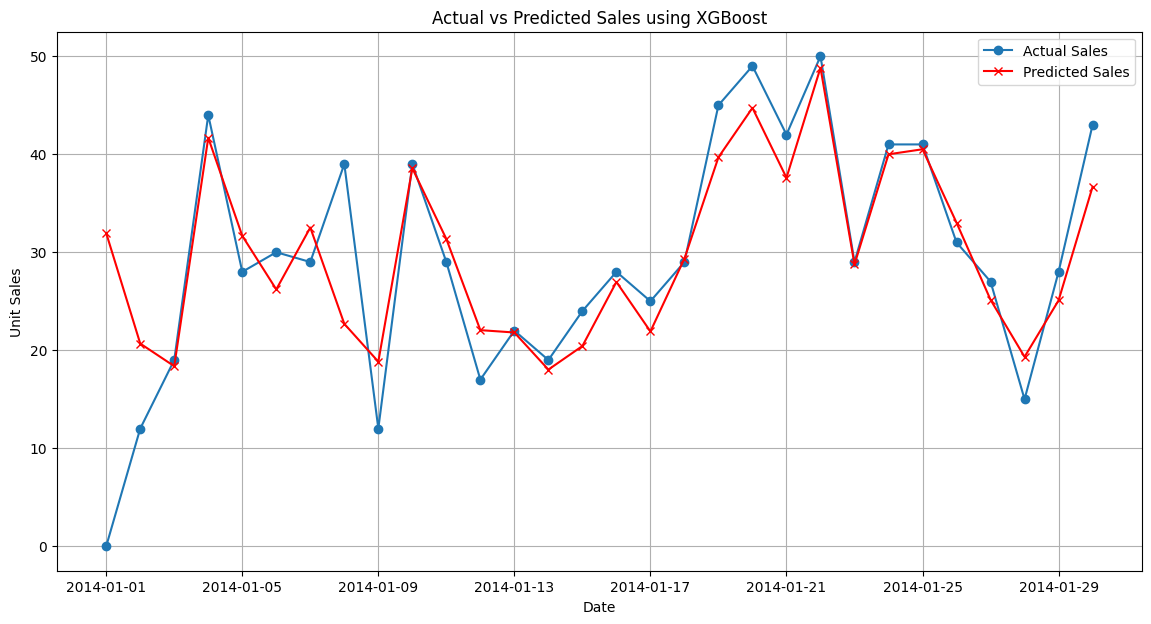

In [ ]:
i = 30
plt.figure(figsize=(14, 7))
plt.plot(test['date'][:i], y_test.values[:i], label='Actual Sales', marker='o')
plt.plot(test['date'][:i], y_pred[:i], label='Predicted Sales', marker='x', color='red')
plt.title(f'Actual vs Predicted Sales using {best_model_name}')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/demand_forecast_plot.png')

In [ ]:
def generate_future_data(store_nbr, item_nbr, start_date, days_ahead, df_train, df_stores, df_items):
    future_dates = pd.date_range(start=start_date, periods=days_ahead, freq='D')
    future_df = pd.DataFrame({
        'date': future_dates,
        'store_nbr': store_nbr,
        'item_nbr': item_nbr,
        'onpromotion': False,
        'year': future_dates.year,
        'month': future_dates.month,
        'day': future_dates.day,
        'day_of_week': future_dates.dayofweek
    })

    # Merge store and item info
    future_df = future_df.merge(df_stores, on='store_nbr', how='left')
    future_df = future_df.merge(df_items, on='item_nbr', how='left')

    # Add lag and rolling features
    last_data = df_train[(df_train['store_nbr'] == store_nbr) & (df_train['item_nbr'] == item_nbr)].tail(30)
    future_df['lag_1'] = np.pad(last_data['unit_sales'].values, (0, days_ahead - len(last_data)), mode='edge')[:days_ahead]
    future_df['lag_7'] = np.pad(last_data['unit_sales'].shift(6).fillna(method='bfill').values, (0, days_ahead - len(last_data)), mode='edge')[:days_ahead]
    future_df['lag_14'] = np.pad(last_data['unit_sales'].shift(13).fillna(method='bfill').values, (0, days_ahead - len(last_data)), mode='edge')[:days_ahead]
    future_df['lag_30'] = np.pad(last_data['unit_sales'].shift(29).fillna(method='bfill').values, (0, days_ahead - len(last_data)), mode='edge')[:days_ahead]
    future_df['unit_sales_7d_avg'] = np.pad(last_data['unit_sales'].rolling(window=7).mean().fillna(method='bfill').values, (0, days_ahead - len(last_data)), mode='edge')[:days_ahead]
    future_df['roll7_std'] = np.pad(last_data['unit_sales'].rolling(window=7).std().fillna(method='bfill').values, (0, days_ahead - len(last_data)), mode='edge')[:days_ahead]
    future_df['pct_chg_7d'] = np.pad(last_data['unit_sales'].pct_change(periods=7).fillna(0).values, (0, days_ahead - len(last_data)), mode='edge')[:days_ahead]

    # Add is_weekend
    future_df['is_weekend'] = future_df['day_of_week'].isin([5, 6]).astype('bool')

    # Ensure categorical columns
    categorical_cols = ['store_nbr', 'item_nbr', 'family', 'city', 'state', 'store_type', 'class']
    for col in categorical_cols:
        if col in future_df.columns:
            future_df[col] = future_df[col].astype('category')

    # Ensure feature order matches training
    return future_df[feature_cols]

Dropdown(description='Store:', index=4, options=(24, 26, 27, 28, 30, 32, 34, 35, 36, 51), value=30)

Dropdown(description='Item:', index=43, options=(111397, 115611, 115892, 115894, 116017, 153267, 155500, 16555…

IntSlider(value=50, description='Days:', max=180, min=10, step=10)

Button(description='Plot Prediction', style=ButtonStyle())

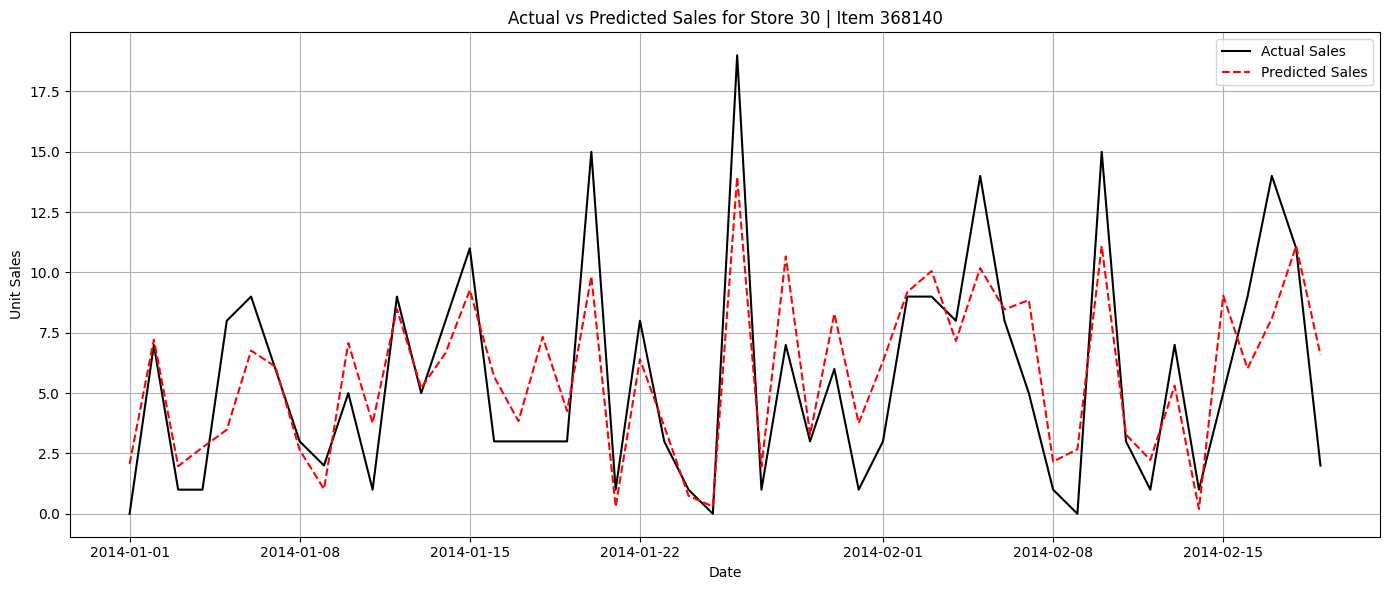

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

# Define dropdowns based on unique store and item values
store_options = sorted(test['store_nbr'].unique())
item_options = sorted(test['item_nbr'].unique())

store_dropdown = widgets.Dropdown(options=store_options, description='Store:')
item_dropdown = widgets.Dropdown(options=item_options, description='Item:')
days_slider = widgets.IntSlider(value=60, min=10, max=180, step=10, description='Days:')

# Button to trigger plot
plot_button = widgets.Button(description="Plot Prediction")

# Function to filter and plot
def plot_selected_prediction(store, item, days):
    mask = (test['store_nbr'] == store) & (test['item_nbr'] == item)
    subset_dates = test.loc[mask, 'date']
    subset_actual = y_test[mask].values
    subset_pred = y_pred[mask]

    if len(subset_actual) == 0:
        print("No data found for selected store/item.")
        return

    subset_dates = subset_dates[:days]
    subset_actual = subset_actual[:days]
    subset_pred = subset_pred[:days]

    plt.figure(figsize=(14, 6))
    plt.plot(subset_dates, subset_actual, label='Actual Sales', color='black')
    plt.plot(subset_dates, subset_pred, label='Predicted Sales', color='red', linestyle='--')
    plt.title(f"Actual vs Predicted Sales for Store {store} | Item {item}")
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Handler for button click
def on_plot_button_clicked(b):
    clear_output(wait=True)
    display(store_dropdown, item_dropdown, days_slider, plot_button)
    plot_selected_prediction(store_dropdown.value, item_dropdown.value, days_slider.value)

plot_button.on_click(on_plot_button_clicked)

# Show widgets
display(store_dropdown, item_dropdown, days_slider, plot_button)


In [ ]:
pickle_path = '/content/drive/MyDrive/models/best_demand_forecast_model.pkl'
with open(pickle_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"Best model saved as pickle file at: {pickle_path}")

Best model saved as pickle file at: /content/drive/MyDrive/models/best_demand_forecast_model.pkl


In [ ]:
import os

model_dir = '/content/drive/MyDrive/models'
os.makedirs(model_dir, exist_ok=True)


In [ ]:
import pickle

model_path = os.path.join(model_dir, f'{best_model_name}_forecast_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"Model saved at: {model_path}")


Model saved at: /content/drive/MyDrive/models/XGBoost_forecast_model.pkl
